<a href="https://colab.research.google.com/github/AbuKaisar24/COVID-19-in-Bangladesh-Time-Series/blob/master/BD_COVID_19_Time_Series_Recovery_Case_Update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.3.0)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [ ]:
RANDOM_SEED = 42
TEST_SIZE = 0.3
LOOK_BACK = 1
BATCH_SIZE = 1
EPOCHS = 100
DAYS_TO_PREDICT = 30
Location="Bangladesh"
Train_case = 'Recovery'

In [ ]:
np.random.seed(RANDOM_SEED)

In [ ]:
df=pd.read_csv("gdrive/My Drive/Colab Notebooks/Covid-19_BD_Update.csv")

In [ ]:
df.head()

,Date,Confirmed,Deaths,Recovery
0,5/13/2020,1162,19,214
1,5/14/2020,1041,14,242
2,5/15/2020,1202,15,279
3,5/16/2020,930,16,235
4,5/17/2020,1273,14,256


In [ ]:
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)

In [ ]:
df.head()

,Confirmed,Deaths,Recovery
Date,,,
2020-05-13,1162,19,214
2020-05-14,1041,14,242
2020-05-15,1202,15,279
2020-05-16,930,16,235
2020-05-17,1273,14,256


In [ ]:
cases = df.filter([Train_case])
cases = cases[(cases.T != 0).any()]

In [ ]:
cases.head()

,Recovery
Date,
2020-05-13,214
2020-05-14,242
2020-05-15,279
2020-05-16,235
2020-05-17,256


In [ ]:
cases.shape

(64, 1)

In [ ]:
def data_split(data, look_back=1):
    x, y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back), 0]
        x.append(a)
        y.append(data[i + look_back, 0])
    return np.array(x), np.array(y)

In [ ]:
test_size = TEST_SIZE
test_size = int(cases.shape[0] * test_size)
train_cases = cases[:-test_size]
test_cases = cases[-test_size:]

In [ ]:
train_cases.shape

(45, 1)

In [ ]:
test_cases.shape

(19, 1)

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(cases)
all_cases = scaler.transform(cases)
train_cases = scaler.transform(train_cases)
test_cases = scaler.transform(test_cases)

In [ ]:
all_cases.shape,train_cases.shape,test_cases.shape

((64, 1), (45, 1), (19, 1))

In [ ]:
look_back = LOOK_BACK
X_all, Y_all = data_split(all_cases, look_back=look_back)
X_train, Y_train = data_split(train_cases, look_back=look_back)
X_test, Y_test = data_split(test_cases, look_back=look_back)

In [ ]:
X_all.shape,X_train.shape,X_test.shape

((62, 1), (43, 1), (17, 1))

In [ ]:
X_all = np.array(X_all).reshape(X_all.shape[0], 1, 1)
Y_all = np.array(Y_all).reshape(Y_all.shape[0], 1)
X_train = np.array(X_train).reshape(X_train.shape[0], 1, 1)
Y_train = np.array(Y_train).reshape(Y_train.shape[0], 1)
X_test = np.array(X_test).reshape(X_test.shape[0], 1, 1)
Y_test = np.array(Y_test).reshape(Y_test.shape[0], 1)

In [ ]:
X_all.shape,Y_all.shape,X_train.shape,Y_train.shape,X_test.shape,Y_test.shape

((62, 1, 1), (62, 1), (43, 1, 1), (43, 1), (17, 1, 1), (17, 1))

In [ ]:
batch_size = BATCH_SIZE
model = Sequential()
model.add(LSTM(4, return_sequences=True, 
               batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), 
               stateful=True))
model.add(LSTM(1, stateful=True))
model.add(Dense(Y_train.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 1, 4)                 96        
_________________________________________________________________
lstm_1 (LSTM)                (1, 1)                    24        
_________________________________________________________________
dense (Dense)                (1, 1)                    2         
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________
None


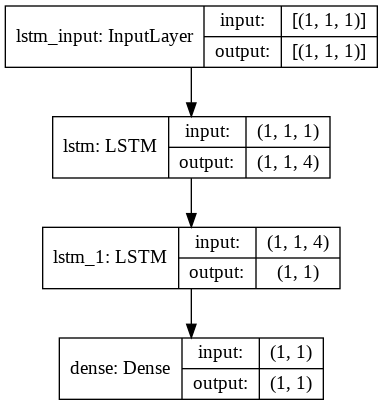

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
epoch = EPOCHS
loss = []
for i in range(epoch):
    print('Iteration ' + str(i + 1) + '/' + str(epoch))
    model.fit(X_train, Y_train, batch_size=batch_size, 
              epochs=1, verbose=1, shuffle=False)
    h = model.history
    loss.append(h.history['loss'][0])
    model.reset_states()

Iteration 1/100
43/43 [==============================] - 0s 2ms/step - loss: 0.8555
Iteration 2/100
43/43 [==============================] - 0s 2ms/step - loss: 0.7145
Iteration 3/100
43/43 [==============================] - 0s 2ms/step - loss: 0.5777
Iteration 4/100
43/43 [==============================] - 0s 2ms/step - loss: 0.4186
Iteration 5/100
43/43 [==============================] - 0s 2ms/step - loss: 0.2474
Iteration 6/100
43/43 [==============================] - 0s 2ms/step - loss: 0.1570
Iteration 7/100
43/43 [==============================] - 0s 2ms/step - loss: 0.1349
Iteration 8/100
43/43 [==============================] - 0s 2ms/step - loss: 0.1289
Iteration 9/100
43/43 [==============================] - 0s 2ms/step - loss: 0.1260
Iteration 10/100
43/43 [==============================] - 0s 2ms/step - loss: 0.1240
Iteration 11/100
43/43 [==============================] - 0s 2ms/step - loss: 0.1223
Iteration 12/100
43/43 [==============================] - 0s 2ms/step - lo

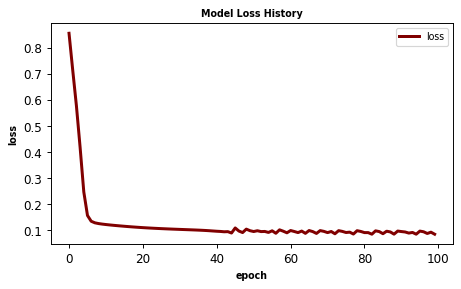

In [ ]:
plt.figure(figsize=(6,4),dpi=86)
plt.plot(loss, label='loss',color='Maroon',linewidth=2.5)
plt.title('Model Loss History',fontsize=8,fontweight='bold')
plt.xlabel('epoch',fontsize=8,fontweight='bold')
plt.ylabel('loss',fontsize=8,fontweight='bold')
plt.legend(prop={"size":8})
plt.tight_layout(3)
plt.show()

In [ ]:
train_predict = model.predict(X_train, batch_size=batch_size)

days_to_predict = X_test.shape[0]
test_predict = []
pred_samples = train_predict[-1:]
pred_samples = np.array([pred_samples])
for i in range(days_to_predict):
    pred = model.predict(X_test[i:(i+1)], batch_size=batch_size)
    pred = np.array(pred).flatten()
    test_predict.append(pred)
test_predict = np.array(test_predict).reshape(1, len(test_predict), 1)

In [ ]:
model.reset_states()

In [ ]:
X_train_flatten = np.array(scaler.inverse_transform(
    np.array(X_train).reshape(X_train.shape[0], 1)
)).flatten().astype('int')
Y_train_flatten = np.array(scaler.inverse_transform(
    np.array(Y_train).reshape(Y_train.shape[0], 1)
)).flatten().astype('int')
train_predict_flatten = np.array(scaler.inverse_transform(
    np.array(train_predict).reshape(train_predict.shape[0], 1)
)).flatten().astype('int')
X_test_flatten = np.array(scaler.inverse_transform(
    np.array(X_test).reshape(X_test.shape[0], 1)
)).flatten().astype('int')
Y_test_flatten = np.array(scaler.inverse_transform(
    np.array(Y_test).reshape(Y_test.shape[0], 1)
)).flatten().astype('int')
test_predict_flatten = np.array(scaler.inverse_transform(
    np.array(test_predict).reshape(test_predict.shape[1], 1)
)).flatten().astype('int')

In [ ]:
train_predict_score = math.sqrt(
    mean_squared_error(
        Y_train_flatten, 
        train_predict_flatten
    )
)
test_predict_score = math.sqrt(
    mean_squared_error(
        Y_test_flatten, 
        test_predict_flatten
    )
)

In [ ]:
'Train Score: %.2f RMSE' % (train_predict_score)

'Train Score: 2324.85 RMSE'

In [ ]:
'Test Score: %.2f RMSE' % (test_predict_score)

'Test Score: 1514.24 RMSE'

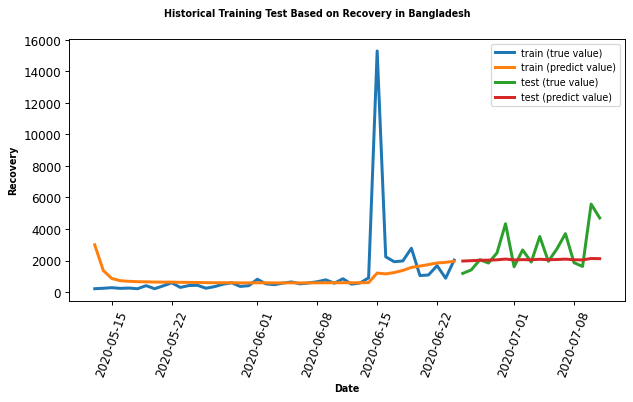

In [ ]:
plt.figure(figsize=(8, 5),dpi=86)
plt.plot(
    cases.index[:len(X_train_flatten)],
    X_train_flatten,
    label='train (true value)',
    linewidth=2.5
)
plt.plot(
    cases.index[:len(train_predict_flatten)],
    train_predict_flatten,
    label='train (predict value)',
    linewidth=2.5
)
plt.plot(
    cases.index[len(X_train_flatten):len(X_train_flatten) + len(X_test_flatten)],
    X_test_flatten,
    label='test (true value)',
    linewidth=2.5
)
plt.plot(
    cases.index[len(X_train_flatten):len(X_train_flatten) + len(test_predict_flatten)],
    test_predict_flatten,
    label='test (predict value)',
    linewidth=2.5
)
plt.suptitle('Historical Training Test Based on Recovery in Bangladesh',fontsize=8,fontweight='bold')
plt.xlabel('Date',fontsize=8,fontweight='bold')
plt.ylabel('Recovery',fontsize=8,fontweight='bold')
plt.xticks(rotation=70)
plt.legend(prop={"size":8})
plt.tight_layout(3)
plt.show()

In [ ]:
model.reset_states()

In [ ]:
epoch = EPOCHS
loss = []
for i in range(epoch):
    print('Iteration ' + str(i + 1) + '/' + str(epoch))
    model.fit(X_all, Y_all, batch_size=batch_size, 
              epochs=1, verbose=1, shuffle=False)
    h = model.history
    loss.append(h.history['loss'][0])
    model.reset_states()

Iteration 1/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0776
Iteration 2/100
62/62 [==============================] - 0s 1ms/step - loss: 0.0754
Iteration 3/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0750
Iteration 4/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0752
Iteration 5/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0754
Iteration 6/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0754
Iteration 7/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0754
Iteration 8/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0752
Iteration 9/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0751
Iteration 10/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0749
Iteration 11/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0746
Iteration 12/100
62/62 [==============================] - 0s 2ms/step - lo

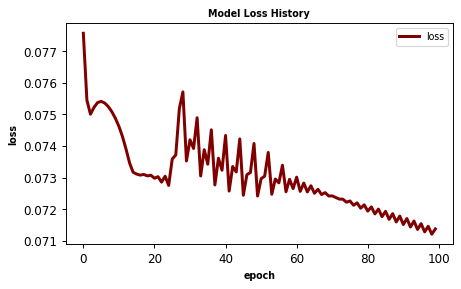

In [ ]:
plt.figure(figsize=(6,4),dpi=86)
plt.plot(loss, label='loss',color='Maroon',linewidth=2.5)
plt.title('Model Loss History',fontsize=8,fontweight='bold')
plt.xlabel('epoch',fontsize=8,fontweight='bold')
plt.ylabel('loss',fontsize=8,fontweight='bold')
plt.legend(prop={"size":8})
plt.tight_layout(3)
plt.show()

In [ ]:
all_predict = model.predict(X_all, batch_size=batch_size)

In [ ]:
days_to_predict = DAYS_TO_PREDICT
future_predict = []
pred_samples = all_predict[-1:]
pred_samples = np.array([pred_samples])
for i in range(days_to_predict):
    pred = model.predict(pred_samples, batch_size=batch_size)
    pred = np.array(pred).flatten()
    future_predict.append(pred)
    new_samples = np.array(pred_samples).flatten()
    new_samples = np.append(new_samples, [pred])
    new_samples = new_samples[1:]
    pred_samples = np.array(new_samples).reshape(1, 1, 1)
future_predict = np.array(future_predict).reshape(len(future_predict), 1, 1)

In [ ]:
model.reset_states()

In [ ]:
f_future_predict = model.predict(future_predict, batch_size=batch_size)

In [ ]:
model.reset_states()

In [ ]:
X_all_flatten = np.array(scaler.inverse_transform(
    np.array(X_all).reshape(X_all.shape[0], 1)
)).flatten().astype('int')
X_all_flatten = np.absolute(X_all_flatten)
Y_all_flatten = np.array(scaler.inverse_transform(
    np.array(Y_all).reshape(Y_all.shape[0], 1)
)).flatten().astype('int')
Y_all_flatten = np.absolute(Y_all_flatten)
all_predict_flatten = np.array(scaler.inverse_transform(
    np.array(all_predict).reshape(all_predict.shape[0], 1)
)).flatten().astype('int')
all_predict_flatten = np.absolute(all_predict_flatten)
future_predict_flatten = np.array(scaler.inverse_transform(
    np.array(future_predict).reshape(future_predict.shape[0], 1)
)).flatten().astype('int')
future_predict_flatten = np.absolute(future_predict_flatten)
f_future_predict_flatten = np.array(scaler.inverse_transform(
    np.array(f_future_predict).reshape(f_future_predict.shape[0], 1)
)).flatten().astype('int')
f_future_predict_flatten = np.absolute(f_future_predict_flatten)

In [ ]:
all_predict_score = math.sqrt(
    mean_squared_error(
        Y_all_flatten, 
        all_predict_flatten
    )
)

In [ ]:
'All Score: %.2f RMSE' % (all_predict_score)

'All Score: 2001.78 RMSE'

In [ ]:
future_index = pd.date_range(start=cases.index[-1], periods=days_to_predict + 1, closed='right')

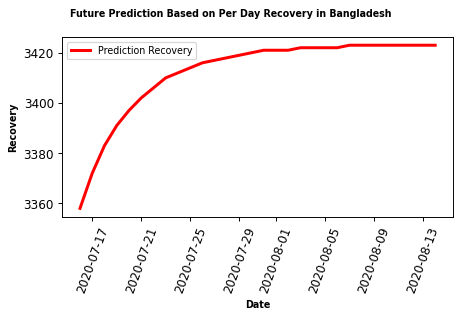

In [ ]:
plt.figure(figsize=(6,4),dpi=86)
plt.plot(
    future_index,
    future_predict_flatten,
    label='Prediction Recovery',
    color='red',
    linewidth=2.5
)
plt.suptitle('Future Prediction Based on Per Day Recovery in Bangladesh',fontsize=8,fontweight='bold')
plt.xlabel('Date',fontsize=8,fontweight='bold')
plt.ylabel('Recovery',fontsize=8,fontweight='bold')
plt.xticks(rotation=70)
plt.legend(prop={"size":8})
plt.tight_layout(3)
plt.show()  

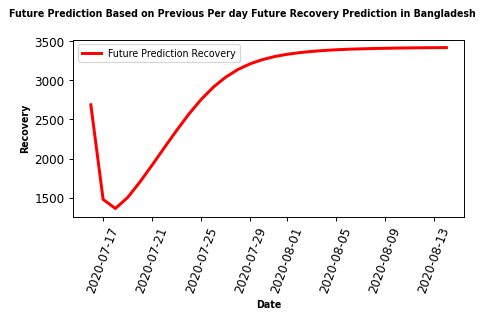

In [ ]:
plt.figure(figsize=(6,4),dpi=86)
plt.plot(
    future_index,
    f_future_predict_flatten,
    label='Future Prediction Recovery',
    color='red',
    linewidth=2.5
)
plt.suptitle('Future Prediction Based on Previous Per day Future Recovery Prediction in Bangladesh',fontsize=8,fontweight='bold')
plt.xlabel('Date',fontsize=8,fontweight='bold')
plt.ylabel('Recovery',fontsize=8,fontweight='bold')
plt.xticks(rotation=70)
plt.legend(prop={"size":8})
plt.tight_layout(3)
plt.show()

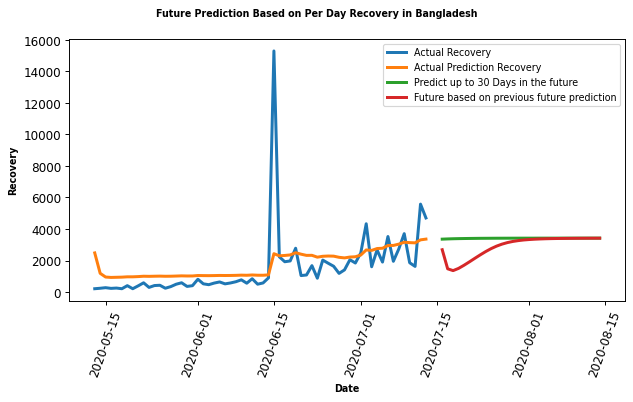

In [ ]:
plt.figure(figsize=(8, 5),dpi=86)
plt.plot(
    cases.index[:len(X_all_flatten)],
    X_all_flatten,
    label='Actual Recovery',
    linewidth=2.5
)
plt.plot(
    cases.index[:len(X_all_flatten)],
    all_predict_flatten,
    label='Actual Prediction Recovery',
    linewidth=2.5
)
plt.plot(
    future_index,
    future_predict_flatten,
    label='Predict up to ' + str(days_to_predict) + ' Days in the future',
    linewidth=2.5
)
plt.plot(
    future_index,
    f_future_predict_flatten,
    label='Future based on previous future prediction',
    linewidth=2.5
)
plt.suptitle('Future Prediction Based on Per Day Recovery in Bangladesh',fontsize=8,fontweight='bold')
plt.xlabel('Date',fontsize=8,fontweight='bold')
plt.ylabel('Recovery',fontsize=8,fontweight='bold')
plt.xticks(rotation=70)
plt.legend(prop={"size":8})
plt.tight_layout(3)
plt.show()

##Random Forest 

In [ ]:
def data_split(data, look_back=1):
    x, y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back), 0]
        x.append(a)
        y.append(data[i + look_back, 0])
    return np.array(x), np.array(y)

In [ ]:
test_size = TEST_SIZE
test_size = int(cases.shape[0] * test_size)
train_cases = cases[:-test_size]
test_cases = cases[-test_size:]

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(cases)
all_cases = scaler.transform(cases)
train_cases = scaler.transform(train_cases)
test_cases = scaler.transform(test_cases)

In [ ]:
look_back = LOOK_BACK
X_all, Y_all = data_split(all_cases, look_back=look_back)
X_train, Y_train = data_split(train_cases, look_back=look_back)
X_test, Y_test = data_split(test_cases, look_back=look_back)

In [ ]:
X_train.shape,Y_train.shape,X_test.shape,Y_test.shape

((43, 1), (43,), (17, 1), (17,))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor()
model = rf.fit(X_train, Y_train)

In [ ]:
all_predict = model.predict(X_all)

In [ ]:
Y_train_flatten = np.array(scaler.inverse_transform(
    np.array(Y_train).reshape(Y_train.shape[0], 1)
)).flatten().astype('int')
Y_test_flatten = np.array(scaler.inverse_transform(
    np.array(Y_test).reshape(Y_test.shape[0], 1)
)).flatten().astype('int')
all_predict_flatten = np.array(scaler.inverse_transform(
    np.array(all_predict).reshape(all_predict.shape[0], 1)
)).flatten().astype('int')
all_predict_flatten = np.absolute(all_predict_flatten)

In [ ]:
y_train_predict=model.predict(X_train)
y_test_predict=model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error
import math

print('Train RMSE')
print(math.sqrt(mean_squared_error(Y_train_flatten,y_train_predict)))
print('Test RMSE')
print(math.sqrt(mean_squared_error(Y_test_flatten,y_test_predict)))

Train RMSE
2534.4552361475344
Test RMSE
3152.1186918923786


In [ ]:
all_predict_score = math.sqrt(
    mean_squared_error(
        Y_all_flatten, 
        all_predict_flatten
    )
)
print("All RMSE :",all_predict_score)

All RMSE : 1244.067457459473


##SVR

In [ ]:
from sklearn.svm import SVR  
svr = SVR(kernel='rbf', gamma=0.1) 
model2 = svr.fit(X_train, Y_train)

In [ ]:
y_train_predict=model2.predict(X_train)

In [ ]:
y_train_predict

array([-0.89697662, -0.89655452, -0.89599659, -0.89666005, -0.89634343,
       -0.89700677, -0.89405019, -0.89697662, -0.89424642, -0.89133169,
       -0.89574019, -0.89394452, -0.89367278, -0.89650929, -0.89498589,
       -0.89266106, -0.89130147, -0.89477463, -0.89408038, -0.88788526,
       -0.89231367, -0.89311412, -0.89158855, -0.89050056, -0.89234388,
       -0.89148279, -0.89028897, -0.88847494, -0.89170941, -0.8874165 ,
       -0.89263086, -0.89148279, -0.88656964, -0.73398115, -0.86644352,
       -0.87113347, -0.8703808 , -0.85831434, -0.88437672, -0.88383227,
       -0.87485663, -0.88691747, -0.86953826])

In [ ]:
y_test_predict=model2.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error
import math

print('Train RMSE')
print(math.sqrt(mean_squared_error(Y_train_flatten,y_train_predict)))
print('Test RMSE')
print(math.sqrt(mean_squared_error(Y_test_flatten,y_test_predict)))

Train RMSE
2534.6421136418453
Test RMSE
3152.1580506144946


In [ ]:
all_predict = model2.predict(X_all)
all_predict_score = math.sqrt(
    mean_squared_error(
        Y_all_flatten, 
        all_predict_flatten
    )
)
print("All RMSE",all_predict_score)

All RMSE 1244.067457459473
